# Fairness and Transparency Tutorial

COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is a commercially available algorithm used by some law enforcement agencies to predict the likelihood of an individual committing a crime in the future. In the past, concerns have been raised about the accuracy and fairness of the algorithm used by COMPAS, as it has been shown to exhibit racial bias in some cases.

To exemplify fairness and transparency aspects during this tutorial, we will thus work with the COMPAS dataset. This dataset contains the criminal history, jail, and prison time, demographics, and COMPAS risk scores for defendants from the Broward County from 2013 and 2014.

Some relevant resources:
* Methodology description by Propublica: https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm
* Analysis code by Propublica (R): https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb
* Article published by Propublica: https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing

* XAI Stories: https://pbiecek.github.io/xai_stories/story-compas.html

* IBM AI Fairness 360: 
    * https://aif360.mybluemix.net
    * https://github.com/Trusted-AI/AIF360

* SHAP values: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [42]:
# These are the packages that you need for this tutorial 
#!pip3 install numpy
#!pip3 install pandas
#!pip3 install seaborn
#!pip3 install matplotlib
#!pip3 install statsmodels
#!pip3 install scikit-learn
#!pip3 install shap
#!pip3 install aif360[all]

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import shap

import warnings
warnings.filterwarnings('ignore')

# Loading the data

In [41]:
data = pd.read_csv("compas-scores-two-years.csv")
pd.set_option('display.max_columns', None)

print("Shape: ", data.shape)
data.head()

Shape:  (7214, 53)


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


# Columns of Interest:

* **age** - Age of the defendant. It is numeric.
* **age_cat** - Category of Age. It can be < 25, 25-45, >45.
* **sex** - Sex of the defendant. It is either 'Male' or 'Female'
* **race** - Race of the defendant. It can be 'African-American', 'Caucasian', 'Hispanic', 'Asian', or 'Other'.
* **c_charge_degree** - Degree of the crime. It is either M (Misdemeanor), F (Felony), or O (not causing jail time).
* **priors_count** - Count of prior crimes committed by the defendant. It is numeric.
* **days_b_screening_arrest** - Days between the arrest and COMPAS screening.
* **decile_score** - The COMPAS score predicted by the system. It is between 1-10.
* **score_text** - Category of decile score. It can be Low (1-4), Medium (5-7), and High (8-10).
* **is_recid** - A variable to indicate if recidivism was done by the defendant. It can be 0 - no, 1 - yes, -1 - no compas case was found for this person. 
* **two_year_recid** - A variable to indicate if recidivism was done by the defendant within two years.
* **c_jail_in** - Time when the defendant was jailed.
* **c_jail_out** - Time when the defendant was released from the jail.

In [42]:
# Keep a subset of the columns in the original dataset
cols_to_keep = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in',
               'c_jail_out']

data = data[cols_to_keep].copy()

print("Shape: ", data.shape)
data.head()

Shape:  (7214, 13)


,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
3,23,F,African-American,Less than 25,High,Male,1,NaN,8,0,0,NaN,NaN
4,43,F,Other,25 - 45,Low,Male,2,NaN,1,0,0,NaN,NaN


# Pre-processing of the data

We will first filter out some rows that contain missing data:
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail * time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.


In [43]:
data = data[(data["days_b_screening_arrest"] <= 30) &
           (data['days_b_screening_arrest'] >= -30) &
           (data['is_recid'] != -1) &
           (data['c_charge_degree'] != 'O') &
           (data['score_text'] != 'N/A')]

print("Shape: ", data.shape)
data.head()

Shape:  (6172, 13)


,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30


# Data exploration

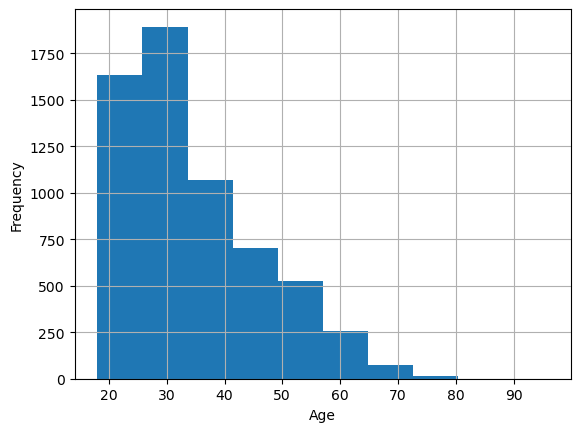

In [44]:
# Plot the age distribution in the Compas dataset
data["age"].hist()
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

Text(0, 0.5, 'Frequency')

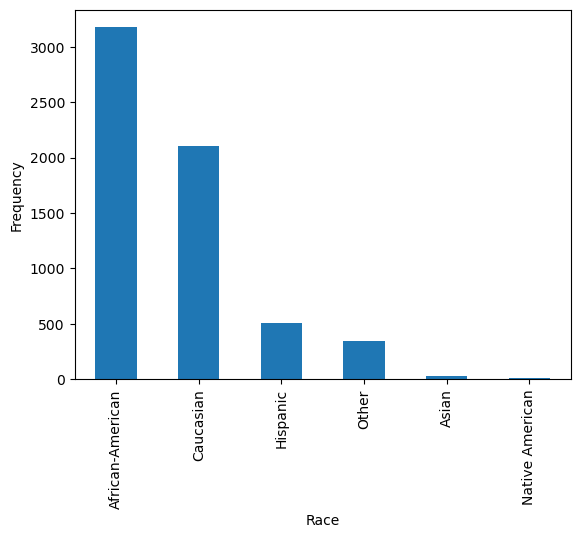

In [45]:
# Plot the race distribution in the Compas dataset
data["race"].value_counts().plot(kind='bar')
plt.xlabel("Race")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

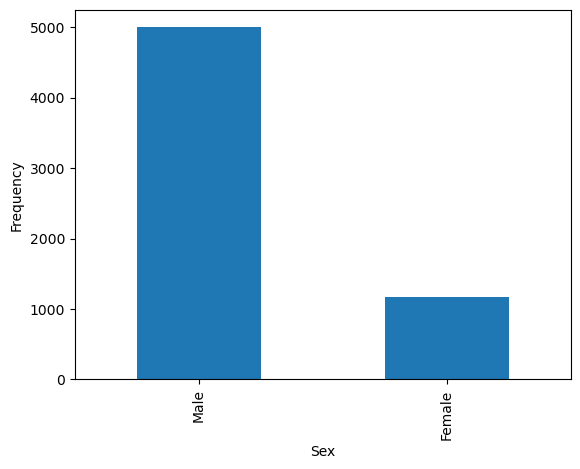

In [46]:
# Plot the distribution of sex in the Compas dataset
data["sex"].value_counts().plot(kind='bar')
plt.xlabel("Sex")
plt.ylabel("Frequency")

## Risk of Recidivism

The column "decile_score" indicates the risk of recidivism within the first two years after release, in the case they are going to commit a crime at all. The "decile_score" contains a value between 1 and 10 for each person in the dataset, where higher values indicate higher likelihood of commiting a crime in the next two years. 

Judges are often presented with this type of information.

Now, we want to see whether there are any differences in the distribution of risk scores by gender and race.

In [47]:
# create a pivot table with the number of people in the Compas dataset, by race and gender
data.pivot_table(values=['decile_score'], columns=['race'], index=['sex'],aggfunc=lambda x: len(x))


decile_score                                               
race   African-American Asian Caucasian Hispanic Native American Other
sex                                                                   
Female              549     2       482       82               2    58
Male               2626    29      1621      427               9   285

# Exploring the variable of interest

Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. 

Are there differences in the distribution of risk scores by gender or race?

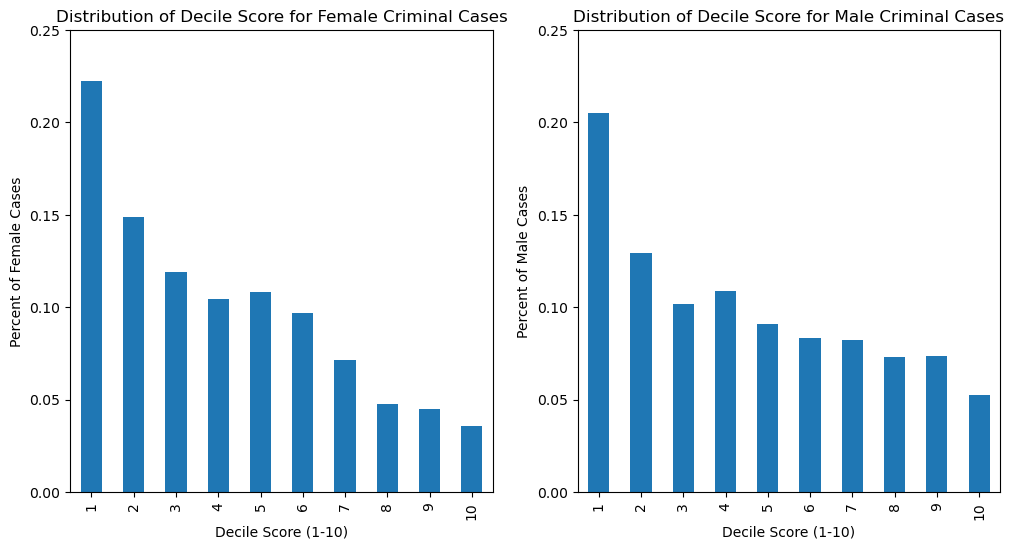

In [48]:
# compute score histograms by gender 
fig = plt.figure(figsize=(12,6))
fig.add_subplot(121)
(data.loc[(data.sex == 'Female'), "decile_score"].sort_values().value_counts(sort=False)/len(data.loc[(data.sex == 'Female')])).plot(kind='bar')
plt.xlabel("Decile Score (1-10)")
plt.ylabel("Percent of Female Cases")
plt.title("Distribution of Decile Score for Female Criminal Cases")
plt.ylim([0, .25])

fig.add_subplot(122)
(data.loc[(data.sex == 'Male'), "decile_score"].sort_values().value_counts(sort=False)/len(data.loc[(data.sex == 'Male')])).plot(kind='bar')
plt.xlabel("Decile Score (1-10)")
plt.ylabel("Percent of Male Cases")
plt.title("Distribution of Decile Score for Male Criminal Cases")
plt.ylim([0, .25])


plt.show()

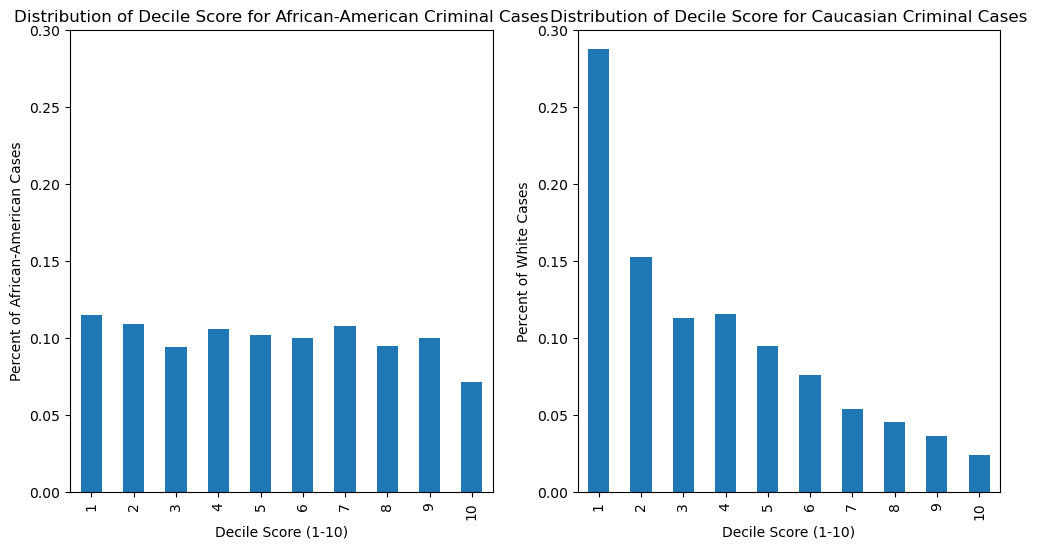

In [49]:
# compute score histograms by race 
fig = plt.figure(figsize=(12,6))
fig.add_subplot(121)

(data.loc[(data.race == 'African-American'), "decile_score"].sort_values().value_counts(sort=False)/len(data.loc[(data.race == 'African-American')])).plot(kind='bar')
plt.xlabel("Decile Score (1-10)")
plt.ylabel("Percent of African-American Cases")
plt.title("Distribution of Decile Score for African-American Criminal Cases")
plt.ylim([0, .3])

fig.add_subplot(122)
(data.loc[(data.race == 'Caucasian'), "decile_score"].sort_values().value_counts(sort=False)/len(data.loc[(data.race == 'Caucasian')])).plot(kind='bar')
plt.xlabel("Decile Score (1-10)")
plt.ylabel("Percent of White Cases")
plt.title("Distribution of Decile Score for Caucasian Criminal Cases")
plt.ylim([0, .3])


plt.show()

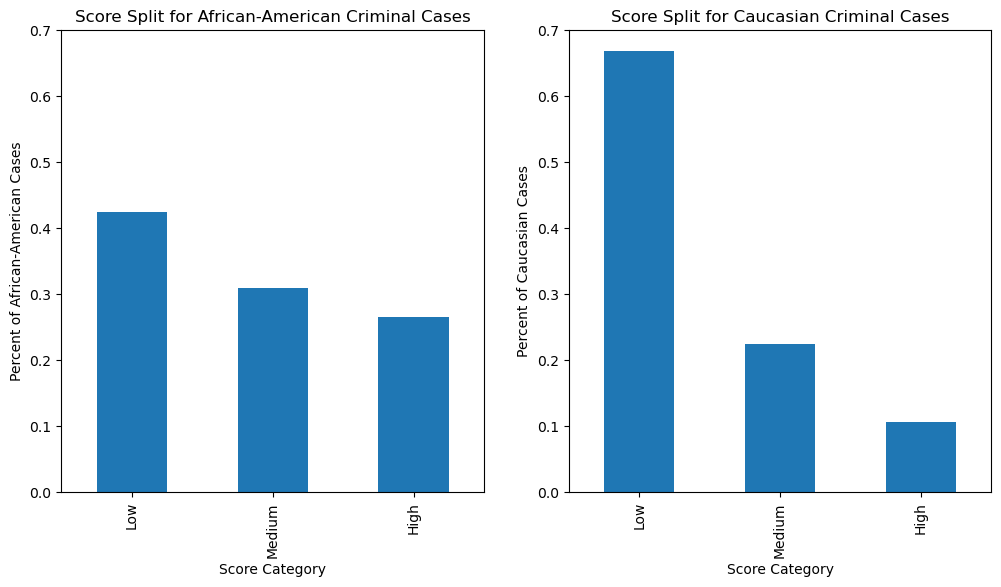

In [50]:
# compute score histograms by race and by gender 
fig = plt.figure(figsize=(12,6))
fig.add_subplot(121)
(data.loc[(data.race == 'African-American'), "score_text"].value_counts().reindex(['Low', 'Medium', 'High'])/len(data.loc[(data.race == 'African-American')])).plot(kind='bar')
plt.xlabel("Score Category")
plt.ylabel("Percent of African-American Cases")
plt.title("Score Split for African-American Criminal Cases")
plt.ylim([0, .7])

fig.add_subplot(122)
(data.loc[(data.race == 'Caucasian'), "score_text"].value_counts().reindex(['Low', 'Medium', 'High'])/len(data.loc[(data.race == 'Caucasian')])).plot(kind='bar')
plt.xlabel("Score Category")
plt.ylabel("Percent of Caucasian Cases")
plt.title("Score Split for Caucasian Criminal Cases")
plt.ylim([0, .7])


plt.show()

## Racial Bias in Compas

Now, we can more rigorously determine if there are significant difference in Compas scores between races. To do so, we need to change some variables into categorical variables and explode them using pandas dummies function, and run a logistic regression model that predicts whether a defendant is of low or high risk of recidivism, given their attributes.

After creating the model, we will look at the effects of the race, gender, and age variables while reducing the effect of confounding variables. It means that when looking at the effect of one variable, the effects of all other variable predictors are taken into account by making the other variables take on a fixed value.

Before we proceed further, we will need to convert all our attributes to numeric as logistic regression takes only numeric attributes.

In [58]:
# Show the current data types.
print(data.dtypes)

age                          int64
c_charge_degree             object
race                        object
age_cat                     object
score_text                  object
sex                         object
priors_count                 int64
days_b_screening_arrest    float64
decile_score                 int64
is_recid                     int64
two_year_recid               int64
c_jail_in                   object
c_jail_out                  object
dtype: object


The attributes which are of dtype object are not numeric. Let us inspect what values they take.


In [59]:
for i, col_type in enumerate(data.dtypes):
    if col_type == "object":
        print("\nColumn {} takes the following values: {}".format(data.columns[i], data[data.columns[i]].unique()))


Column c_charge_degree takes the following values: ['F' 'M']

Column race takes the following values: ['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']

Column age_cat takes the following values: ['Greater than 45' '25 - 45' 'Less than 25']

Column score_text takes the following values: ['Low' 'Medium' 'High']

Column sex takes the following values: ['Male' 'Female']

Column c_jail_in takes the following values: ['2013-08-13 06:03:42' '2013-01-26 03:45:27' '2013-04-13 04:58:34' ...
 '2014-01-13 05:48:01' '2014-03-08 08:06:02' '2014-06-28 12:16:41']

Column c_jail_out takes the following values: ['2013-08-14 05:41:20' '2013-02-05 05:36:53' '2013-04-14 07:02:04' ...
 '2014-01-14 07:49:46' '2014-03-09 12:18:04' '2014-06-30 11:19:23']


All of the above variables except for c_jail_in and c_jail_out are categorical variables. So, let's convert the dtype of the above columns to category and then create dummy variables for each value of the variables. We also have to drop one of the dummies created from eah categorical variable to avoid multicollinearity.

In [60]:
data_lr = data.copy(deep=True)

# Change variable types
data_lr['c_charge_degree'] = data_lr['c_charge_degree'].astype('category')
data_lr['age_cat'] = data_lr['age_cat'].astype('category')
data_lr['race'] = data_lr['race'].astype('category')
data_lr['sex'] = data_lr['sex'].astype('category')
data_lr['score_text'] = data_lr['score_text'].astype('category')

# Explode c_charge_degree using get_dummies
dummies_c_charge_degree = pd.get_dummies(data_lr['c_charge_degree'])
data_lr = pd.concat([data_lr, dummies_c_charge_degree], axis=1)
data_lr = data_lr.drop(['c_charge_degree'], axis=1)

# Explode age_cat using get_dummies
dummies_age_cat = pd.get_dummies(data_lr['age_cat'])
data_lr = pd.concat([data_lr, dummies_age_cat], axis=1)
data_lr = data_lr.drop(['age_cat', '25 - 45'], axis=1)

# Explode race using get_dummies
dummies_race = pd.get_dummies(data_lr['race'])
data_lr = pd.concat([data_lr, dummies_race], axis=1)
data_lr = data_lr.drop(['race', 'Caucasian'], axis=1)

# Explode sex using get_dummies
dummies_sex = pd.get_dummies(data_lr['sex'])
data_lr = pd.concat([data_lr, dummies_sex], axis=1)
data_lr = data_lr.drop(['sex', 'Male'], axis=1)

# Converting score_text to take binary values 
# Low = LowScore, Medium and High = HighScore
data_lr['score_text']= np.where(data_lr['score_text'] == "Low", "LowScore", data_lr['score_text'])
data_lr['score_text']= np.where(data_lr['score_text'] != "LowScore", "HighScore", data_lr['score_text'])
data_lr['score_text'] = data_lr['score_text'].astype('category')

# We rename the columns because the statsmodel does not like spaces in the variable names.
renamed_cols = {'African-American':'African_American', 'Greater than 45':'Greater_than_45', 
                'Less than 25':'Less_than_25', 'Native American':'Native_American', 'F': 'Felony',
               'M': 'Misdemeanor'}

data_lr = data_lr.rename(columns=renamed_cols)

print(data_lr.columns)
data_lr.head()

Index(['age', 'score_text', 'priors_count', 'days_b_screening_arrest',
       'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out',
       'Felony', 'Misdemeanor', 'Greater_than_45', 'Less_than_25',
       'African_American', 'Asian', 'Hispanic', 'Native_American', 'Other',
       'Female'],
      dtype='object')


,age,score_text,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out,Felony,Misdemeanor,Greater_than_45,Less_than_25,African_American,Asian,Hispanic,Native_American,Other,Female
0,69,LowScore,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,1,0,1,0,0,0,0,0,1,0
1,34,LowScore,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53,1,0,0,0,1,0,0,0,0,0
2,24,LowScore,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04,1,0,0,1,1,0,0,0,0,0
5,44,LowScore,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,0,1,0,0,0,0,0,0,1,0
6,41,HighScore,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30,1,0,0,0,0,0,0,0,0,0


Now, we will set up the formula for the logistic regression, and fit the model. 

For this exercise, we will fit the model on the entire dataset. Normally, to actually develop a model with good predictive capability, we would need to split our dataset into training and testing and run cross-validation to get the best hyperparameters for the model.

In [61]:
# Explanatory variables
attributes = 'priors_count + two_year_recid + Misdemeanor + Greater_than_45 + Less_than_25 + \
African_American + Asian + Hispanic + Native_American + Other + Female'

# Target variable
target = 'score_text'

# Formula
formula = target + ' ~ ' + attributes
print(formula)

score_text ~ priors_count + two_year_recid + Misdemeanor + Greater_than_45 + Less_than_25 + African_American + Asian + Hispanic + Native_American + Other + Female


In [62]:

# Fit the model 
# Note: using family=sm.families.Binomial() tells statsmodel to fit a logistic regression
model = sm.formula.glm(formula=formula, family=sm.families.Binomial(), data = data_lr).fit()

print(model.summary())

                                 Generalized Linear Model Regression Results                                 
Dep. Variable:     ['score_text[HighScore]', 'score_text[LowScore]']   No. Observations:                 6172
Model:                                                           GLM   Df Residuals:                     6160
Model Family:                                               Binomial   Df Model:                           11
Link Function:                                                 Logit   Scale:                          1.0000
Method:                                                         IRLS   Log-Likelihood:                -3084.2
Date:                                               Tue, 06 Dec 2022   Deviance:                       6168.4
Time:                                                       15:30:20   Pearson chi2:                 6.07e+03
No. Iterations:                                                    6   Pseudo R-squ. (CS):             0.3128
Covariance

From the above table, we see an overview of the coefficients of the model, how well those coefficients fit, the overall fit quality, and several other statistical measures.
To compare the odds of two variables happening, we can get the odds ratio of those two variables.

Mathematically, this would be:

$$\ln{(\frac{y}{1-y})} = w_0 + w_1 x_1$$
where, for instance, $x_1$ = Female, then -> when $x_1 = 1$ it is Female, when $x_1 = 0$ it is Male 

Therefore,

$w_0 + w_1$ = log odds of high recividism for Female defendants, 
$w_0$ = log odds of high recividism for Male defendants. 
To get the odds (and not the log odds), we transform the above equation to get:

$e^{w_0 + w_1}$ = odds of high recividism for Female defendants, 
$e^{w_0}$ = odds of high recividism for Male defendants, 
To get the odd ratio, we divide the two odds to compare them.
To compare age and race variables, it is the same procedure. 

In the case of age 
$x_1$ = Less_than_25 
then -> when $x_1 = 1$, the age is less than 25, when $x_1 = 0$, the age is between 25 - 45 

Therefore, 
$e^{w_0 + w_1}$ = odds of high recividism for defendants whose age is less than 25, 
$e^{w_0}$ = odds of high recividism for defendants whose age is between 25 - 45 

In the case of race 
$x_1$ = African-American 
then -> when $x_1 = 1$, the defendant is an African-American, when $x_1 = 0$, the defendant is a Caucasian 

Therefore, 
$e^{w_0 + w_1}$ = odds of high recividism for an African-American defendant, 
$e^{w_0}$ = odds of high recividism for a Caucasian defendant 

In [64]:
model_odds = pd.DataFrame(np.exp(model.params), columns= ['OR'])
model_odds['z-value']= model.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(model.conf_int())
model_odds

,OR,z-value,2.5%,97.5%
Intercept,0.217504,4.303325e-84,0.186481,0.253687
priors_count,1.308584,1.338321e-129,1.280412,1.337375
two_year_recid,1.985484,8.814130e-27,1.751349,2.250919
Misdemeanor,0.732537,2.911452e-06,0.642961,0.834594
Greater_than_45,0.257784,1.298682e-42,0.212285,0.313036
Less_than_25,3.700213,1.532449e-66,3.188571,4.293954
African_American,1.611567,5.934215e-12,1.406754,1.846199
Asian,0.775370,5.947169e-01,0.303707,1.979536
Hispanic,0.651554,8.271232e-04,0.506862,0.837551
Native_American,4.031779,6.878450e-02,0.898205,18.097480


## Comparing the odds

### African American vs. Caucasian

In [66]:
african_american_odds = np.exp(-1.5255+0.4772)
caucasian_odds = np.exp(-1.5255)

race_odd_ratio = african_american_odds / caucasian_odds

print("Odd Ratio:", sex_odd_ratio)

Odd Ratio: 1.611555722969869


This means that the odds of high recividism is about 1.6 times greater for an African-American defendant than a Caucasian defendant (when all the other variables are controlled for).

This means that race is quite predictive of a higher score. While African-American defendants had higher recidivism rates overall, when adjusted for this difference and other factors, they were more likely to get a higher score than Caucasians.

## Woman vs. Men

In [67]:
women_odds = np.exp(-1.5255+0.22127)
men_odds = np.exp(-1.5255)

sex_odd_ratio = women_odds / men_odds

print("Odd Ratio:", sex_odd_ratio)

Odd Ratio: 1.2476602533593484


This means that the odds of high recividism is about 1.25 times greater for a Female defendant than a Male defendant (when all the other variables are controlled for).

Surprisingly, given their lower levels of criminality overall, female defendants are more likely to get a higher score than men, when controlling for the same factors.

## Young vs Middle-Aged

In [68]:
young_odds = np.exp(-1.5255+1.30839)
middle_odds = np.exp(-1.5255)

age_odd_ratio = young_odds / middle_odds

print("Odd Ratio:", age_odd_ratio)

Odd Ratio: 3.7002115733431995


This means that the odds of high recividism is about 3.7 times greater for a Young defendant than a Middle-Aged defendant (when all the other variables are controlled for).

# IBM AI Fairness 360 Toolkit

In [51]:
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.explainers import MetricTextExplainer
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas

In [52]:
dataset = load_preproc_data_compas()
dataset_train, dataset_test = dataset.split([0.7], shuffle=True)

In [53]:
print(dataset_train.protected_attribute_names)

['sex', 'race']


We start by looking at **race**:

In [54]:
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

metric = BinaryLabelDatasetMetric(dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = -0.132279


### Disparate Impact

Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.

The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group.

Fairness for this metric is between 0.8 and 1.25

In [55]:
explainer_train = MetricTextExplainer(metric)

print(explainer_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.7828387025392317


### Statistical Parity Difference 

Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.

The ideal value of this metric is 0

Fairness for this metric is between -0.1 and 0.1

In [56]:
print(explainer_train.statistical_parity_difference())

Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -0.13227942084985456


We continue by looking at **gender**:

In [57]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

metric = BinaryLabelDatasetMetric(dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = -0.135037


### Disparate Impact

Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.

The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group.

Fairness for this metric is between 0.8 and 1.25

In [58]:
explainer_train = MetricTextExplainer(metric)

print(explainer_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.788415280444698


### Statistical Parity Difference 

Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.

The ideal value of this metric is 0

Fairness for this metric is between -0.1 and 0.1

In [59]:
print(explainer_train.statistical_parity_difference())

Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -0.1350366105406292


# Apply bias mitigation technique - Reweighing (pre-processing method) 

Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification.

It is based on the following publication: F. Kamiran and T. Calders,  "Data Preprocessing Techniques for Classification without Discrimination," Knowledge and Information Systems, 2012.

In [61]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

In [62]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset)
dataset_transf_train = RW.transform(dataset)

In [67]:
dataset_transf_train

               instance weights            features                        \
                                protected attribute                         
                                                sex race age_cat=25 to 45   
instance names                                                              
3                      0.946907                 0.0  0.0              1.0   
4                      0.946907                 0.0  0.0              0.0   
8                      0.946907                 0.0  1.0              1.0   
10                     0.829746                 1.0  1.0              1.0   
14                     1.052423                 0.0  1.0              1.0   
...                         ...                 ...  ...              ...   
10994                  0.946907                 0.0  0.0              1.0   
10995                  1.052423                 0.0  0.0              0.0   
10996                  1.052423                 0.0  0.0              0.0   

In [63]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
print("#### Transformed training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset
Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [64]:
explainer_train = MetricTextExplainer(metric_transf_train)

print(explainer_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0000000000000002


In [65]:
explainer_train = MetricTextExplainer(metric_transf_train)

print(explainer_train.statistical_parity_difference())

Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): 1.1102230246251565e-16


# Using the SHAP library to inspect feature importance for model predictions

We will use a simple binary classification that aims to predict whether a person has a **Low** or **High** risk of  recidivism according to COMPAS. For this we will use the data in the **score_text** as follows:
* the negative class is represented by entries in the dataset that have a **Low** score
* the positive class is represented by entries in the dataset that have a **Medium** or a **High** score

We start by preparing the data similarly as in the case of the logic regression (see above), in which we expand the values in each column of interest.

In [21]:
# Preprocess the data

data_c = data_lr

# Make the COMPASS label column numeric (0 and 1), for use in our model
data_c['COMPASS_determination'] = np.where(data_c['score_text'] == 'LowScore', 0, 1)

# Get list of all columns from the dataset we will use for model input or output.
input_features = ['Female', 'age', 'Greater_than_45', 'Less_than_25', 'African_American', 'Hispanic', 'Native_American', 'Other', 'priors_count', 'Felony', 'Misdemeanor']

to_keep = input_features + ['two_year_recid', 'COMPASS_determination']

to_remove = [col for col in data_c.columns if col not in to_keep]
data_c = data_c.drop(columns=to_remove)

data_c.head()


,age,priors_count,two_year_recid,Felony,Misdemeanor,Greater_than_45,Less_than_25,African_American,Hispanic,Native_American,Other,Female,COMPASS_determination
0,69,0,0,1,0,1,0,0,0,0,1,0,0
1,34,0,1,1,0,0,0,1,0,0,0,0,0
2,24,4,1,1,0,0,1,1,0,0,0,0,0
5,44,0,0,0,1,0,0,0,0,0,1,0,0
6,41,14,1,1,0,0,0,0,0,0,0,0,1


In [22]:
data_c

,age,priors_count,two_year_recid,Felony,Misdemeanor,Greater_than_45,Less_than_25,African_American,Hispanic,Native_American,Other,Female,COMPASS_determination
0,69,0,0,1,0,1,0,0,0,0,1,0,0
1,34,0,1,1,0,0,0,1,0,0,0,0,0
2,24,4,1,1,0,0,1,1,0,0,0,0,0
5,44,0,0,0,1,0,0,0,0,0,1,0,0
6,41,14,1,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,23,0,0,1,0,0,1,1,0,0,0,0,1
7210,23,0,0,1,0,0,1,1,0,0,0,0,0
7211,57,0,0,1,0,1,0,0,0,0,1,0,0
7212,33,3,0,0,1,0,0,1,0,0,0,1,0


We prepare the training and testing dataset. We use 80% of the data as training and 20% as testing.

In [27]:
# Import train_test_split function

X=data_c[input_features]  # Features
y=data_c['two_year_recid']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80% training and 20% test

In [28]:
#Create a Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets 
classifier.fit(X_train,y_train)

y_pred = classifier.predict(X_test)

In [29]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6340080971659919


Now that we have the predictions, we can use the SHAP values to explain the output of our classifier.

## Local Interpretability

We are going to inspect some individual observations and understand which were the features or variables that influenced the prediction the most.

In [34]:
X_test_instances = X_test.copy(True)
X_test_instances["Predicted"] = y_pred
X_test_instances["COMPAS"] = y_test
X_test_instances.tail(10)

,Female,age,Greater_than_45,Less_than_25,African_American,Hispanic,Native_American,Other,priors_count,Felony,Misdemeanor,Predicted,COMPAS
2351,0,26,0,0,0,0,0,0,0,0,1,0,0
235,0,52,1,0,1,0,0,0,0,1,0,1,0
1315,0,27,0,0,1,0,0,0,4,1,0,1,1
1547,0,46,1,0,1,0,0,0,0,1,0,1,0
196,0,23,0,1,1,0,0,0,0,1,0,0,1
2576,0,43,0,0,1,0,0,0,6,0,1,1,1
6061,0,26,0,0,1,0,0,0,2,0,1,0,0
3323,1,24,0,1,1,0,0,0,0,0,1,0,0
6371,0,48,1,0,0,0,0,1,0,0,1,0,0
1183,1,29,0,0,0,0,0,0,11,1,0,1,1


In [35]:
print("Test instance: ", X_test_instances.loc[1315])

Test instance:  Female               0
age                 27
Greater_than_45      0
Less_than_25         0
African_American     1
Hispanic             0
Native_American      0
Other                0
priors_count         4
Felony               1
Misdemeanor          0
Predicted            1
COMPAS               1
Name: 1315, dtype: int64


In [36]:
# Calculate Shap values
explainer = shap.TreeExplainer(classifier)
choosen_instance = X_test_instances.loc[4189]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

What you see above is a force plot visualizing shapley values for the features. Feature values in pink/red cause to increase the prediction. Size of the bar shows the magnitude of the feature's effect. Feature values in blue cause to decrease the prediction. 

In **bold**, you can see the value predicted for the given instance.

The "base value" refers to the value that whould have been predicted of we did not know any of ther features in the current output, which is basically the mean prediction (mean(y_pred)).


The model predicted 0.56 (Reoffend), whereas the base_value is 0.46. The biggest effect for this prediction is the the age, the fact that it is African American, and male which increased the changes of the model to predict that the person will reoffend. The number of priors decreased the chances of predicting that the person with reoffend. 

In [37]:
print("Test instance: ", X_test_instances.loc[235])

Test instance:  Female               0
age                 52
Greater_than_45      1
Less_than_25         0
African_American     1
Hispanic             0
Native_American      0
Other                0
priors_count         0
Felony               1
Misdemeanor          0
Predicted            1
COMPAS               0
Name: 235, dtype: int64


In [38]:
# Calculate Shap values
explainer = shap.TreeExplainer(classifier)
choosen_instance = X_test_instances.loc[235]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [39]:
print("Test instance: ", X_test_instances.loc[196])

Test instance:  Female               0
age                 23
Greater_than_45      0
Less_than_25         1
African_American     1
Hispanic             0
Native_American      0
Other                0
priors_count         0
Felony               1
Misdemeanor          0
Predicted            0
COMPAS               1
Name: 196, dtype: int64


In [40]:
# Calculate Shap values
explainer = shap.TreeExplainer(classifier)
choosen_instance = X_test_instances.loc[196]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

## Global Interpretability

The collective SHAP values can show how much each predictor contributes, either positively or negatively, to the target variable.

Using 4937 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1235 [00:00<?, ?it/s]

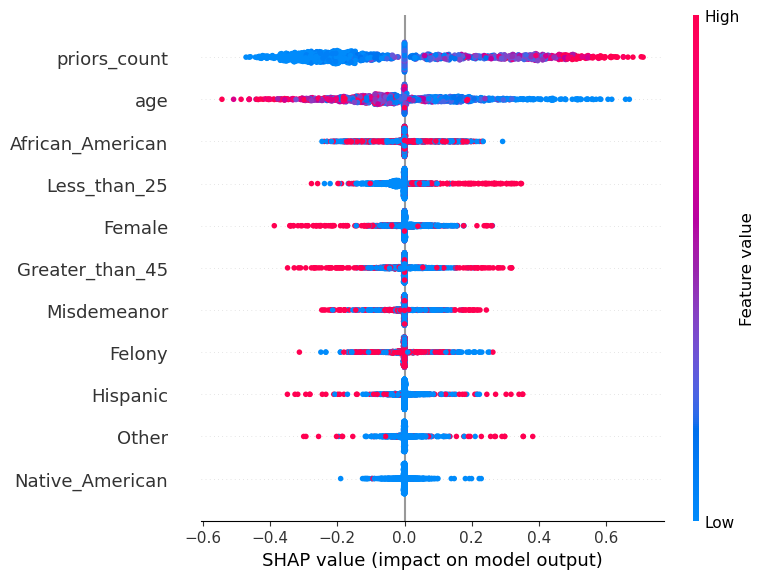

In [41]:
# Create Tree Explainer object that can calculate shap values
shap.initjs()
explainer = shap.KernelExplainer(classifier.predict,X_train)
shap_values_rf = explainer.shap_values(X_test, nsamples=50)
shap.summary_plot(shap_values_rf, X_test)

In the summary plot, the variables are ranked based on their importance in descending order. On the horizontal axis, we can see whether each variable has an effect toward a lower (blue value) or higher (red color) prediction value.